# 5. Validation Data
*Written by Men Vuthy, 2021*

---

**Import packages**

In [1]:
import os
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

### 5.1 Paddy Points

**Create raster image based on no-noise data**

In [2]:
# Read data
DF_NDVI = pd.read_csv('output/3/no_noise_data/no_noise_ndvi.csv')

In [3]:
DF_NDVI = DF_NDVI.iloc[4:, :].reset_index(drop=True)

In [4]:
NDVI = DF_NDVI.T
NDVI.insert(0, 'id', NDVI.index[:])

In [5]:
# Add one image for projection and shape reference
raster = rasterio.open("input/ndvi_2011/2010_01_01.tif")

In [6]:
# Re-arrange cluster range
indx = []
for i in range(0,392313):
    indx.append(i)
    
Index = pd.DataFrame()
Index['id'] = indx

df1 = Index.set_index('id')
df2 = NDVI.set_index('id')
df2 = NDVI.set_index(df2.index.astype('int64')).drop(columns=['id'])
mask = df2.index.isin(df1.index)

for i, j in zip(range(len(df2.columns)), df2.columns):
    df1[j] = df2.loc[mask, j]
    
Smooth_NDVI = df1

In [7]:
# Reshape the cluster array
Array_list = []

for i in range(len(Smooth_NDVI.columns)):
    array = np.array(Smooth_NDVI[i])
    NDVI_array = array.reshape(raster.read().shape)
    Array_list.append(NDVI_array)

In [8]:
# Create array of smooth ndvi
NDVI_array = np.array(Array_list)
NDVI_array = np.moveaxis(NDVI_array, [0, 1, 2, 3], [1, 0, 2, 3])
NDVI_array = NDVI_array[0]
NDVI_array.shape

(65, 521, 753)

**Export image as tiff**

In [9]:
# Data dir
data_dir = "output/4/no_noise_img"

# Output raster
out_tif = os.path.join(data_dir, "no_noise_ndvi.tif")

# Copy the metadata
out_meta = raster.meta.copy()
out_meta

# Update the metadata
out_meta.update({'driver': 'GTiff',
                 'dtype': 'float32',
                 'nodata': None,
                 'width': raster.shape[1],
                 'height': raster.shape[0],
                 'crs': raster.crs,
                 'count':65,
                 'transform': raster.transform
                })

In [10]:
with rasterio.open(out_tif, "w", **out_meta) as dest:
    dest.write(NDVI_array.astype(np.float32))

**NDVI timeseries at allpaddy points**

In [11]:
# Read data
NDVI_img = rasterio.open('output/4/no_noise_img/no_noise_ndvi.tif')
NN_NDVI = NDVI_img.read()

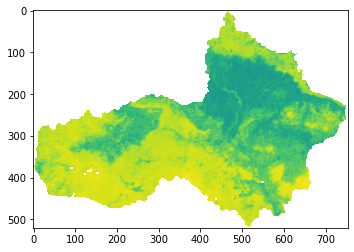

In [12]:
plt.imshow(NN_NDVI[0]);

**Paddy Points**

In [13]:
paddy = gpd.read_file('input/paddy_point/paddy_points.shp')

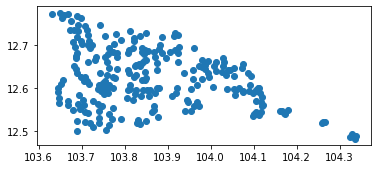

In [14]:
paddy.plot();

**Extract ndvi based on paddy points**

In [15]:
NDVI_List = []

for point in paddy['geometry']:
    
    for i in range(1, NN_NDVI.shape[0]+1):

        # Select row and column
        x = point.xy[0][0]
        y = point.xy[1][0]

        # Locate x and y of point to get row and col of raster
        row, col = NDVI_img.index(x, y)

        # Extract band value
        ndvi = NDVI_img.read(i)[row,col]
        
        # Append to list
        NDVI_List.append(ndvi)


In [16]:
# Create array of ndvi
ndvi_array = np.array(NDVI_List)

# Reshape array of ndvi
ndvi_reshape = ndvi_array.reshape((len(paddy['geometry']),NN_NDVI.shape[0]))

# Create ndvi dataframe
DF_Validation = pd.DataFrame(ndvi_reshape).T
DF_Validation

,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
0,0.30656,0.30070,0.30872,0.300300,0.37614,0.31070,0.30242,0.29408,0.29544,0.26586,...,0.30484,0.29380,0.27422,0.27342,0.31036,0.304780,0.31180,0.27698,0.30098,0.29138
1,0.29246,0.28526,0.29392,0.284140,0.32442,0.30164,0.28660,0.27876,0.27948,0.25624,...,0.29132,0.28620,0.27160,0.26406,0.29812,0.294360,0.29170,0.26322,0.28980,0.27682
2,0.27646,0.26858,0.27812,0.266300,0.28486,0.29054,0.27436,0.25870,0.26574,0.24814,...,0.27436,0.27408,0.25940,0.25310,0.28879,0.277280,0.27496,0.25308,0.28497,0.26114
3,0.25586,0.25887,0.26424,0.254440,0.26746,0.28112,0.26374,0.24062,0.25246,0.24176,...,0.26446,0.26924,0.25938,0.25504,0.28456,0.281160,0.27192,0.24560,0.28063,0.25934
4,0.24462,0.24799,0.25640,0.248320,0.25348,0.28048,0.26200,0.23238,0.24636,0.24074,...,0.25602,0.26310,0.25464,0.24824,0.28728,0.292160,0.27214,0.24758,0.28195,0.25890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,0.41578,0.56593,0.68400,0.680193,0.60364,0.64858,0.67000,0.49599,0.63586,0.54138,...,0.41742,0.43984,0.28020,0.66948,0.37100,0.314643,0.38560,0.30576,0.38422,0.46544
61,0.48096,0.57599,0.58410,0.556433,0.47780,0.53500,0.54704,0.49667,0.57608,0.58816,...,0.50790,0.50404,0.36424,0.63130,0.42864,0.380443,0.42784,0.36670,0.45080,0.47698
62,0.53590,0.58783,0.52778,0.427653,0.38446,0.45966,0.44826,0.50061,0.52678,0.60048,...,0.56946,0.51574,0.37734,0.58740,0.46686,0.452003,0.42184,0.43670,0.51632,0.48336
63,0.56918,0.55715,0.44346,0.378940,0.36458,0.44692,0.39998,0.50132,0.45886,0.63756,...,0.58910,0.54578,0.42698,0.54918,0.58010,0.549100,0.46714,0.56082,0.57142,0.53050


**Save result**

In [17]:
DF_Validation.to_csv('output/4/validation_data/validation_paddy.csv', index = False)

Visualize data

In [18]:
DF_Validation = pd.read_csv('output/4/validation_data/validation_paddy.csv')

Text(0.5, 1.0, '2011 NDVI Timeseries')

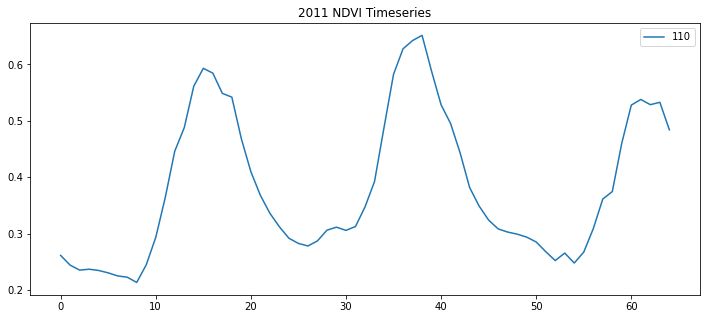

In [19]:
i = 110 # column number or pixel numer
j = i+1

# Plot between noised and smoothed ndvi
fig, ax = plt.subplots(figsize=(12,5))
ax = DF_Validation.iloc[:,i:j].plot(ax=ax)
ax.set_title('2011 NDVI Timeseries')

---

### 5.2 Paddy Classes

**Visualize data**

In [20]:
# Arrange dataframe for plot
DF_Validation = pd.read_csv('output/4/validation_data/validation_paddy.csv').T

Date = pd.read_csv('output/2/date_img/date_img.csv').iloc[:65]

date = []
for i in Date.iloc[:].values:
    date.append(i[0])

DF_Validation.columns = date

DF_Validation = DF_Validation.T

Text(0.5, 1.0, '2011 NDVI Timeseries')

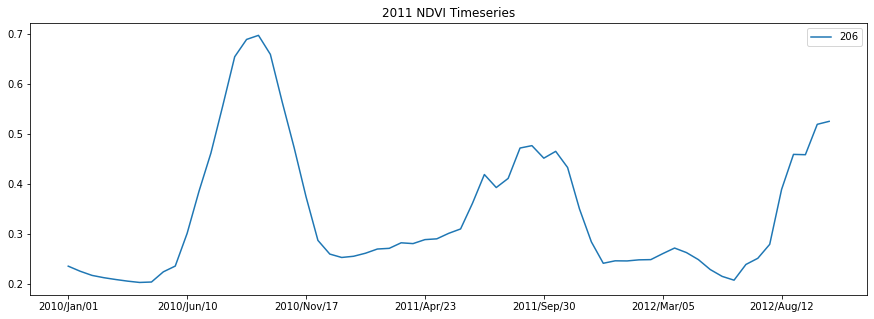

In [21]:
i = 206 # column number or pixel numer
j = i+1

# Plot between noised and smoothed ndvi
fig, ax = plt.subplots(figsize=(15,5))
ax = DF_Validation.iloc[:,i:j].plot(ax=ax)
ax.set_title('2011 NDVI Timeseries')

In [22]:
Date = pd.read_csv('output/2/date_img/date_img.csv').iloc[:65]